In [1]:
import pandas as pd
import numpy as np
import torch
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('fer3and4train.csv')
test = pd.read_csv('fer3and4test.csv')

In [3]:
w = 48
h = 48

train_data = train['pixels'].tolist()
train_data_list = []
for pixels in train_data:
    pixel_seq = [int(pixel) for pixel in pixels.split(' ')]
    pixel_seq = np.asarray(pixel_seq).reshape(w, h)
    train_data_list.append(pixel_seq.astype('float32'))

train_data_list = np.asarray(train_data_list)
train_labels = np.array(train.iloc[:, 0])

In [4]:
test_data = test['pixels'].tolist() # 1
test_data_list = []
for pixels in test_data:
    pixel_seq = [int(pixel) for pixel in pixels.split(' ')]
    pixel_seq = np.asarray(pixel_seq).reshape(w, h)
    test_data_list.append(pixel_seq.astype('float32'))

test_data_list = np.asarray(test_data_list)
test_labels = np.array(test.iloc[:, 0])

In [5]:
train_x, val_x, train_y, val_y = train_test_split(train_data_list, train_labels, test_size = 0.2)
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape)

(((9652, 48, 48), (9652,)), ((2414, 48, 48), (2414,)))

In [6]:
train_x = train_x.reshape(9652, 1, 48, 48)
print(train_x.shape, train_y.shape)

(9652, 1, 48, 48) (9652,)


In [7]:
val_x = val_x.reshape(2414, 1, 48, 48)
print(val_x.shape, val_y.shape)

(2414, 1, 48, 48) (2414,)


In [8]:
train_x  = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)
print(train_x.shape, train_y.shape)

torch.Size([9652, 1, 48, 48]) torch.Size([9652])


In [9]:
val_x  = torch.from_numpy(val_x)
val_y = torch.from_numpy(val_y)
print(val_x.shape, val_y.shape)

torch.Size([2414, 1, 48, 48]) torch.Size([2414])


In [10]:
test_x = test_data_list.reshape(3000, 1, 48, 48)
test_x  = torch.from_numpy(test_x)
test_y = torch.from_numpy(test_labels)
print(test_x.shape, test_y.shape)

torch.Size([3000, 1, 48, 48]) torch.Size([3000])


In [11]:
class Convolution_Network(Module):   
    def __init__(self):
        super(Convolution_Network, self).__init__()
        self.cnn_layer_1 = Sequential(
            Conv2d(1, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2))
        self.cnn_layer_2 = Sequential(
            Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
            BatchNorm2d(4),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=2, stride=2))
        self.fully_conn = Sequential(Linear(4 * 12 * 12, 5))

    def forward(self, x):
        x = self.cnn_layer_1(x)
        x = self.cnn_layer_2(x)
        x = x.view(x.size(0), -1)
        x = self.fully_conn(x)
        return x

In [12]:
model = Convolution_Network()
optimizer = Adam(model.parameters(), lr=0.002)
criterion = CrossEntropyLoss()
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
print(model)

Convolution_Network(
  (cnn_layer_1): Sequential(
    (0): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (cnn_layer_2): Sequential(
    (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fully_conn): Sequential(
    (0): Linear(in_features=576, out_features=5, bias=True)
  )
)


In [13]:
def train_CNN_model(epoch):
    model.train()
    total_loss = 0
    X_train, Y_train = Variable(train_x), Variable(train_y)
    X_val, Y_val = Variable(val_x), Variable(val_y)
    if torch.cuda.is_available():
        X_train = X_train.cuda()
        Y_train = Y_train.cuda()
        X_val = X_val.cuda()
        Y_val = Y_val.cuda()
        
    train_Y_tensor = torch.tensor(Y_train, dtype=torch.long)
    val_Y_tensor = torch.tensor(Y_val, dtype=torch.long)
    optimizer.zero_grad()
    train_result = model(X_train)
    val_result = model(X_val)
    tloss = criterion(train_result, train_Y_tensor)
    training.append(tloss.item())
    vloss = criterion(val_result, val_Y_tensor)
    validation.append(vloss.item())
    tloss.backward()
    optimizer.step()
    total_loss = tloss.item()
    print('Epoch : ',epoch+1, '\t', 'Loss :', vloss.item(), '\t', 'Accuracy :', (1 - vloss.item()))

In [14]:
n_epochs = 120
training = []
validation = []
for epoch in range(n_epochs):
    train_CNN_model(epoch)

Epoch :  1 	 Loss : 1.6504815816879272 	 Accuracy : -0.6504815816879272
Epoch :  2 	 Loss : 1.0584543943405151 	 Accuracy : -0.05845439434051514
Epoch :  3 	 Loss : 0.8583572506904602 	 Accuracy : 0.1416427493095398
Epoch :  4 	 Loss : 0.7810029983520508 	 Accuracy : 0.21899700164794922
Epoch :  5 	 Loss : 0.7416887879371643 	 Accuracy : 0.2583112120628357
Epoch :  6 	 Loss : 0.7170997262001038 	 Accuracy : 0.28290027379989624
Epoch :  7 	 Loss : 0.699863612651825 	 Accuracy : 0.30013638734817505
Epoch :  8 	 Loss : 0.6876837611198425 	 Accuracy : 0.31231623888015747
Epoch :  9 	 Loss : 0.6787760853767395 	 Accuracy : 0.3212239146232605
Epoch :  10 	 Loss : 0.6719338893890381 	 Accuracy : 0.3280661106109619
Epoch :  11 	 Loss : 0.6665310263633728 	 Accuracy : 0.3334689736366272
Epoch :  12 	 Loss : 0.6622203588485718 	 Accuracy : 0.3377796411514282
Epoch :  13 	 Loss : 0.6586905121803284 	 Accuracy : 0.34130948781967163
Epoch :  14 	 Loss : 0.6556938886642456 	 Accuracy : 0.34430611133

In [15]:
train_pred_values = model(train_x)
train_act_fn = torch.exp(train_pred_values).cpu()
train_values = list(train_act_fn.detach().numpy())
train_pred = np.argmax(train_values, axis=1)
train_acc = accuracy_score(train_y, train_pred)
print("Training Accuracy Score: ", (100 * train_acc), "%")

Training Accuracy Score:  77.61085785329466 %


In [16]:
val_pred_values = model(val_x)
val_act_fn = torch.exp(val_pred_values).cpu()
validation_values = list(val_act_fn.detach().numpy())
validation_pred = np.argmax(validation_values, axis=1)
val_acc = accuracy_score(val_y, validation_pred)
print("Validation Accuracy Score: ", (100 * val_acc) , "%")

Validation Accuracy Score:  75.51781275890637 %


In [17]:
test_pred_values = model(test_x)
test_act_fn = torch.exp(test_pred_values).cpu()
test_values = list(test_act_fn.detach().numpy())
test_pred = np.argmax(test_values, axis=1)
test_acc = accuracy_score(test_y, test_pred)
print("Test Accuracy Score: ", (100 * test_acc), "%")

Test Accuracy Score:  74.2 %


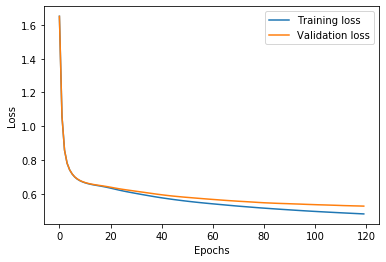

In [18]:
plt.plot(training, label='Training loss')
plt.plot(validation, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()